In [8]:
import json
import os
from pathlib import Path

# your api key
api_key = {
'username':"anna58yt" , # kaggle account just registered
'key':"b854876d62210a798f2bb5de86df8008"}

# uses pathlib Path
kaggle_path = Path('/root/.kaggle')
os.makedirs(kaggle_path, exist_ok=True)

# opens file and dumps python dict to json object
with open (kaggle_path/'kaggle.json', 'w') as handl:
    json.dump(api_key,handl)

os.chmod(kaggle_path/'kaggle.json', 600)


In [9]:
! pip install kaggle
!kaggle datasets download -d fernando2rad/brain-tumor-mri-images-44c

 85% 159M/188M [00:01<00:00, 119MB/s]
100% 188M/188M [00:02<00:00, 98.0MB/s]


In [10]:
import os
import pandas as pd
import numpy as np
import torch
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.utils import to_categorical
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import sklearn.metrics as metrics
from matplotlib.cm import ScalarMappable

## Load + Preprocess Dataset

In [11]:
# uploading the unzipped file directly is painfully slow, so instead upload the zip file and unzip here
# !unzip 'brain_tumor_15.zip' -d brain_tumor/
!unzip 'brain-tumor-mri-images-44c' -d brain_tumor/

Archive:  brain-tumor-mri-images-44c.zip
  inflating: brain_tumor/Astrocitoma T1/005_big_gallery.jpeg  
  inflating: brain_tumor/Astrocitoma T1/006_big_gallery.jpeg  
  inflating: brain_tumor/Astrocitoma T1/01809e58d2c1e7fff56cc5d8520f5a0500e22624a400948250b05f2ae0a1f177_big_gallery.jpeg  
  inflating: brain_tumor/Astrocitoma T1/02df132a56dfb89ece42ee8d195a16_big_gallery.jpeg  
  inflating: brain_tumor/Astrocitoma T1/044d8d9984902ca03e652a6f042c57_big_gallery.jpeg  
  inflating: brain_tumor/Astrocitoma T1/05899aa824a60c863097d3c9105009c18e25246abea155839c216ceab0273a18_big_gallery.jpeg  
  inflating: brain_tumor/Astrocitoma T1/0c14dccd685d7ce330d14fa7a1f53dc756e73aff2f03afc1b09a7efc410f1804_big_gallery.jpeg  
  inflating: brain_tumor/Astrocitoma T1/0fbe78c3db179f94296e3b3d8c05fb_big_gallery.jpeg  
  inflating: brain_tumor/Astrocitoma T1/1492ae4325c115eccae71ebb3e995907dbef123dfd9ed8a32d7f8a64bb03115b_big_gallery.jpeg  
  inflating: brain_tumor/Astrocitoma T1/18e851456478d638929d5109489

In [19]:
# Set the path to your image folder
# image_folder = 'brain_tumor/brain_tumor_15'
image_folder = 'brain_tumor/'

# Define the image size and number of classes
img_size = (128, 128)

In [20]:
# Function to load and preprocess the images
def load_images(folder_path):
    images = []
    labels = []
    label_names = []
    class_dirs = sorted(os.listdir(folder_path))

    for class_index, class_dir in enumerate(class_dirs):
        class_path = os.path.join(folder_path, class_dir)
        if os.path.isdir(class_path):
            label_names.append(class_dir)
            image_files = os.listdir(class_path)
            for image_file in image_files:
                image_path = os.path.join(class_path, image_file)
                image = Image.open(image_path).convert('RGB')
                image = image.resize(img_size)
                image = np.array(image)
                images.append(image)
                labels.append(class_index - 1)

    return np.array(images), np.array(labels), label_names

In [21]:
# Load and preprocess the images
images, labels, label_names = load_images(image_folder)

# Split the dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

In [22]:
# Convert labels to one-hot encoding (binary class matrix)
num_classes = len(np.unique(labels))
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

## CNN Model

In [23]:
# Define the CNN model
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(img_size[0], img_size[1], 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# prep for input into fully connected layer
model.add(Flatten())
# 128 neurons that learns high-level features
model.add(Dense(128, activation='relu'))
# num neurons = num classes. softmax produces final probability distribution
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [24]:
# Check if a GPU is available
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("No GPU found. Please make sure you have enabled GPU acceleration in the Colab notebook settings.")

# Train the model with GPU acceleration
with tf.device('/device:GPU:0'):
    model.fit(x_train, y_train, batch_size=32, epochs=10, validation_data=(x_test, y_test))

Default GPU Device: /device:GPU:0
Epoch 1/10
112/112 [==============================] - 19s 26ms/step - loss: 3.7330 - accuracy: 0.2311 - val_loss: 2.1787 - val_accuracy: 0.4442
Epoch 2/10
112/112 [==============================] - 2s 20ms/step - loss: 1.4792 - accuracy: 0.6202 - val_loss: 1.3286 - val_accuracy: 0.6741
Epoch 3/10
112/112 [==============================] - 2s 20ms/step - loss: 0.7261 - accuracy: 0.8091 - val_loss: 1.0723 - val_accuracy: 0.7344
Epoch 4/10
112/112 [==============================] - 2s 21ms/step - loss: 0.3838 - accuracy: 0.9001 - val_loss: 0.8615 - val_accuracy: 0.8192
Epoch 5/10
112/112 [==============================] - 2s 20ms/step - loss: 0.2101 - accuracy: 0.9473 - val_loss: 0.8500 - val_accuracy: 0.8069
Epoch 6/10
112/112 [==============================] - 3s 24ms/step - loss: 0.1749 - accuracy: 0.9520 - val_loss: 0.9315 - val_accuracy: 0.7969
Epoch 7/10
112/112 [==============================] - 3s 24ms/step - loss: 0.1155 - accuracy: 0.9665 - val_

In [25]:
# Save the model
model.save("my_model.h5")

## Model Evaluation

In [26]:
# Load the saved model
model = keras.models.load_model("my_model.h5")

In [27]:
# Calculate loss + accuracy
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.899169921875
Test accuracy: 0.8404017686843872


In [28]:
label_names

['Astrocitoma T1',
 'Astrocitoma T1C+',
 'Astrocitoma T2',
 'Carcinoma T1',
 'Carcinoma T1C+',
 'Carcinoma T2',
 'Ependimoma T1',
 'Ependimoma T1C+',
 'Ependimoma T2',
 'Ganglioglioma T1',
 'Ganglioglioma T1C+',
 'Ganglioglioma T2',
 'Germinoma T1',
 'Germinoma T1C+',
 'Germinoma T2',
 'Glioblastoma T1',
 'Glioblastoma T1C+',
 'Glioblastoma T2',
 'Granuloma T1',
 'Granuloma T1C+',
 'Granuloma T2',
 'Meduloblastoma T1',
 'Meduloblastoma T1C+',
 'Meduloblastoma T2',
 'Meningioma T1',
 'Meningioma T1C+',
 'Meningioma T2',
 'Neurocitoma T1',
 'Neurocitoma T1C+',
 'Neurocitoma T2',
 'Oligodendroglioma T1',
 'Oligodendroglioma T1C+',
 'Oligodendroglioma T2',
 'Papiloma T1',
 'Papiloma T1C+',
 'Papiloma T2',
 'Schwannoma T1',
 'Schwannoma T1C+',
 'Schwannoma T2',
 'Tuberculoma T1',
 'Tuberculoma T1C+',
 'Tuberculoma T2',
 '_NORMAL T1',
 '_NORMAL T2']

28/28 [==============================] - 0s 6ms/step


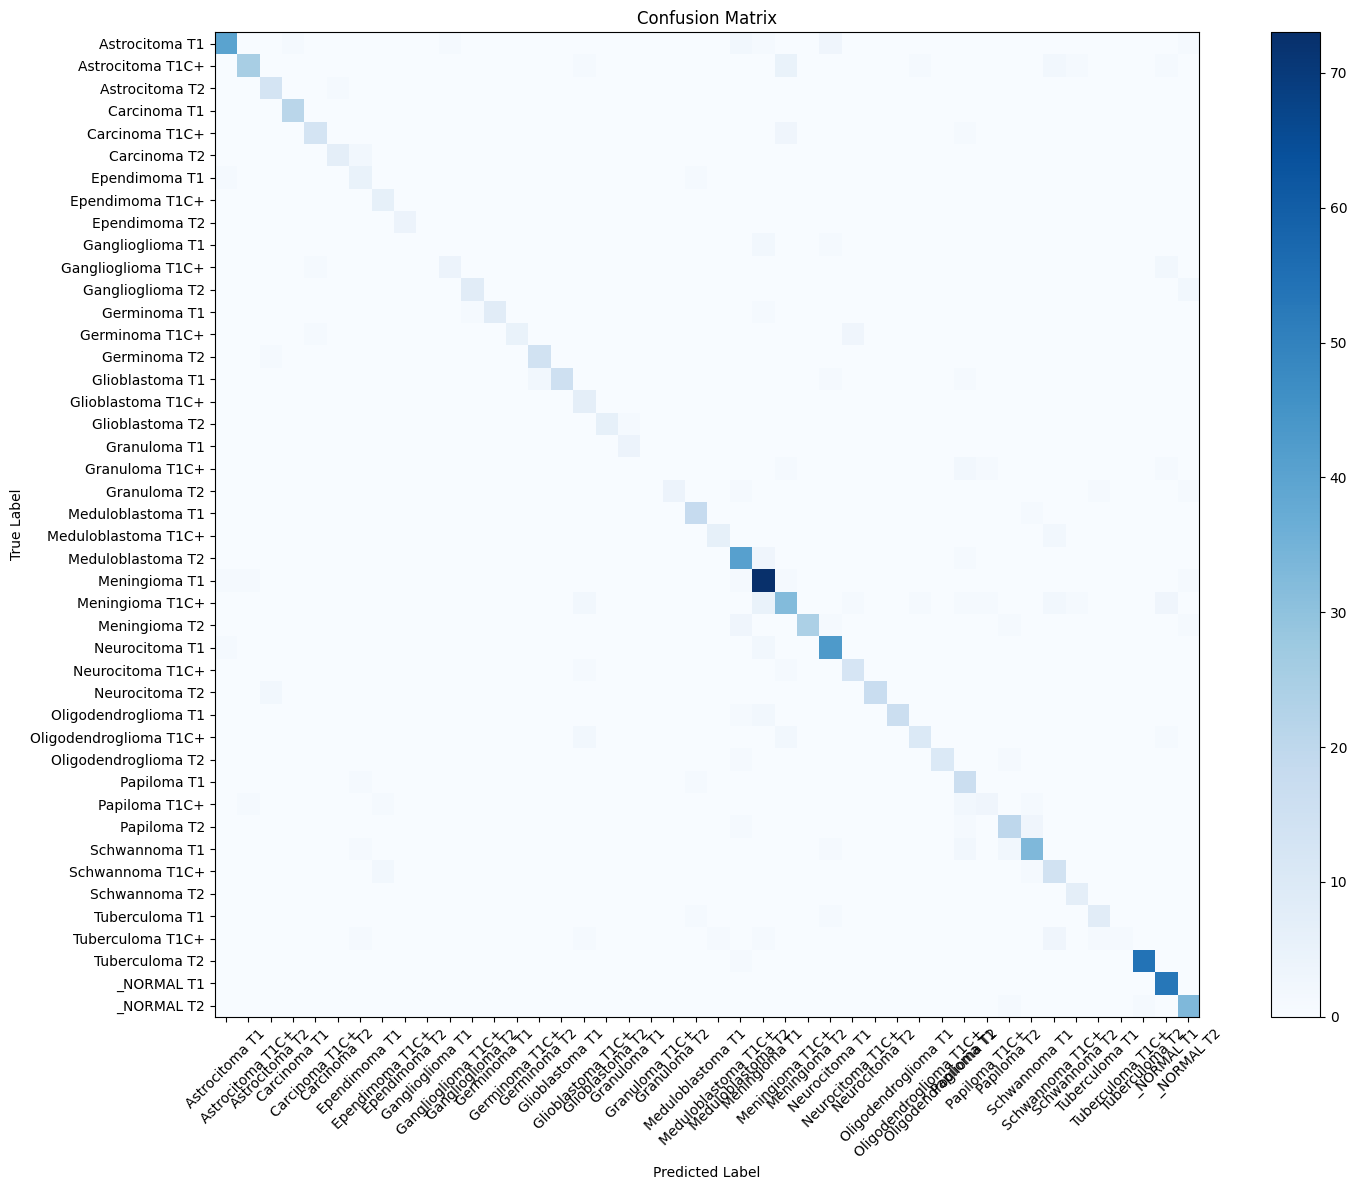

In [29]:
# Generate predictions on the test set
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)  # Convert one-hot encoded predictions to labels

# Convert test labels to labels instead of one-hot encoding
y_true = np.argmax(y_test, axis=1)

# Compute the confusion matrix
confusion_matrix = metrics.confusion_matrix(y_true, y_pred)

# Define class labels (assuming you have a list of class names)
class_labels = label_names  # Replace with your actual class labels

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(16, 12))
plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

In [30]:
# Calculate negative log likelihood
# y_pred_probs = model.predict(x_test)
# nll = -tf.reduce_mean(tf.reduce_sum(y_test * tf.math.log(y_pred_probs), axis=-1))
# print("Negative Log-Likelihood:", nll.numpy())

# Calculate F1 score for each class separately
f1_scores = metrics.f1_score(y_true, y_pred, average=None)

# Calculate the average F1 score
average_f1_score = sum(f1_scores) / len(f1_scores)

print("F1 Scores for Each Class:", f1_scores)
print("Average F1 Score:", average_f1_score)

F1 Scores for Each Class: [0.86956522 0.79365079 0.86666667 0.97674419 0.8125     0.82352941
 0.58823529 0.8        1.         0.         0.66666667 0.84210526
 0.88888889 0.71428571 0.90322581 0.88235294 0.66666667 0.92307692
 0.88888889 0.         0.72727273 0.9        0.8        0.84536082
 0.86904762 0.68085106 0.88888889 0.88659794 0.8        0.94444444
 0.91428571 0.74074074 0.90909091 0.71111111 0.46153846 0.8
 0.84615385 0.7        0.875      0.8        0.2        0.98181818
 0.92982456 0.89189189]
Average F1 Score: 0.7729765512114043


## Attention Map

In [31]:
#get layer names
for layer in model.layers:
    print(layer.name)

conv2d
max_pooling2d
conv2d_1
max_pooling2d_1
conv2d_2
conv2d_3
conv2d_4
max_pooling2d_2
flatten
dense
dense_1


In [34]:
img = x_test[0]
# Convert the NumPy array to a PIL image
pil_image = Image.fromarray(np.uint8(img))

# Save the image to a desired location on your local machine
save_path = "example_image.png"
pil_image.save(save_path)

print("Image downloaded and saved successfully.")

Image downloaded and saved successfully.


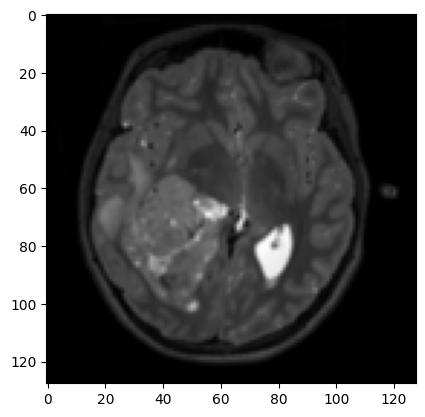

In [ ]:
img = x_test[0]
img = cv2.resize(img, (128, 128))
ax = plt.imshow(img)

In [ ]:
# Convert the image to a tensor and preprocess it
input_image = tf.expand_dims(tf.cast(img, tf.float32), axis=0)
input_image = input_image / 255.0

Given the pretrained model we want to extract the activation maps at a certain layer. We index the layers using natural numbers. The activation maps at a given index is a function of the form

$$f: \mathbb{R}^{H \times W \times 3} \to \mathbb{R}^{H' \times W' \times C}$$

In simple terms, given an input image of three channels the output is a 3-d tensor representing the activation at the given layer.

In [ ]:
def get_activations_at(input_image, i):
  # Load the saved model
  model = keras.models.load_model("my_model.h5")

  # Index the layer
  out_layer = model.layers[i]

  # Specify input + output layer; output layer = layer being examined
  inputs, outputs = model.inputs, out_layer.output

  # Change the output of the model
  model = tf.keras.models.Model(inputs, outputs)

  # Return the activations
  return model.predict(input_image)

After getting the activations in the shape $(H', W', C)$ we want to represent what parts of the image is the activation paying attention to the most. To do that we need to convert the shape of the activations to the form $(H', W')$ or mathematically

$$g: \mathbb{R}^{H' \times W' \times C} \to \mathbb{R}^{H' \times W'} $$

We call $g$ a spatial attention map function  [ref](https://arxiv.org/pdf/1612.03928.pdf). There are many functions that we could use as described by the paper. In this demo we will use the sum of the absolute value of the activations across the channel. Formally, given an activation $A$ we define $A_i = A[:,:,i]$ which represents an index across the channel dimension. Then we can evaluate the attention map as

$$g(A) = \sum_{i=1}^C |A_i|$$


In [ ]:
def postprocess_activations(activations):

  # Using the approach in https://arxiv.org/abs/1612.03928
  output = np.abs(activations)
  output = np.sum(output, axis = -1).squeeze()

  # Resize and convert to image
  output = cv2.resize(output, (128, 128))
  output /= output.max()
  output *= 255
  return 255 - output.astype('uint8')

In [ ]:
def apply_heatmap(weights, img):
  #generate heat maps
  heatmap = cv2.applyColorMap(weights, cv2.COLORMAP_JET)
  heatmap = cv2.addWeighted(heatmap, 0.7, img, 0.3, 0)
  return heatmap

In [ ]:
def plot_heatmaps(rng):
  level_maps = None

  #given a range of indices generate the heat maps
  for i in rng:
    activations = get_activations_at(input_image, i)
    weights = postprocess_activations(activations)
    heatmap = apply_heatmap(weights, img)
    if level_maps is None:
      level_maps = heatmap
    else:
      level_maps = np.concatenate([level_maps, heatmap], axis = 1)
  plt.figure(figsize=(15, 15))
  plt.axis('off')
  ax = plt.imshow(level_maps)

1/1 [==============================] - 0s 82ms/step


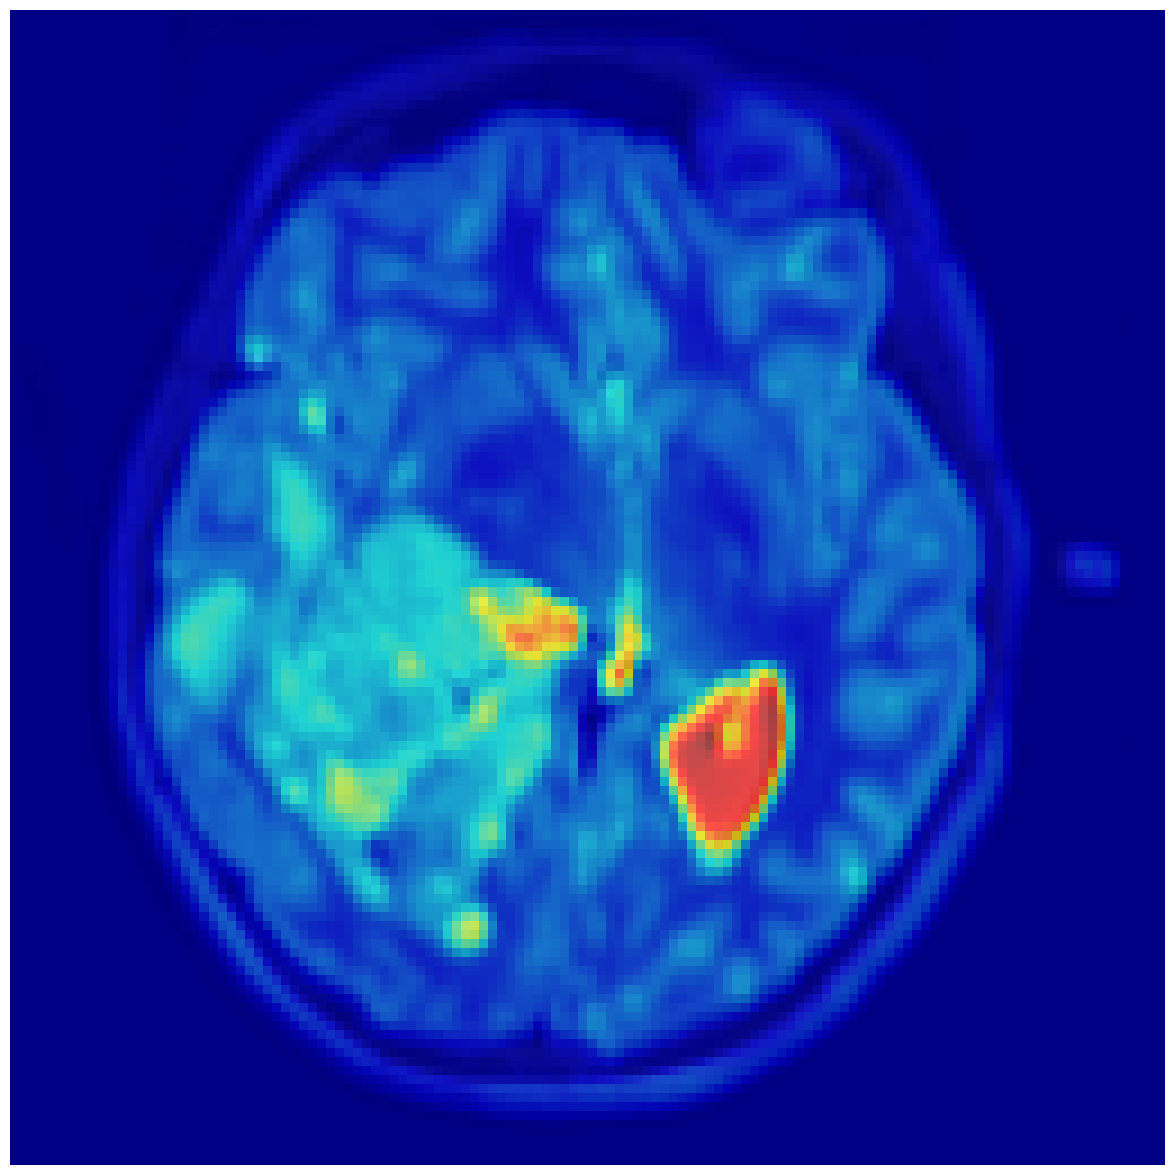

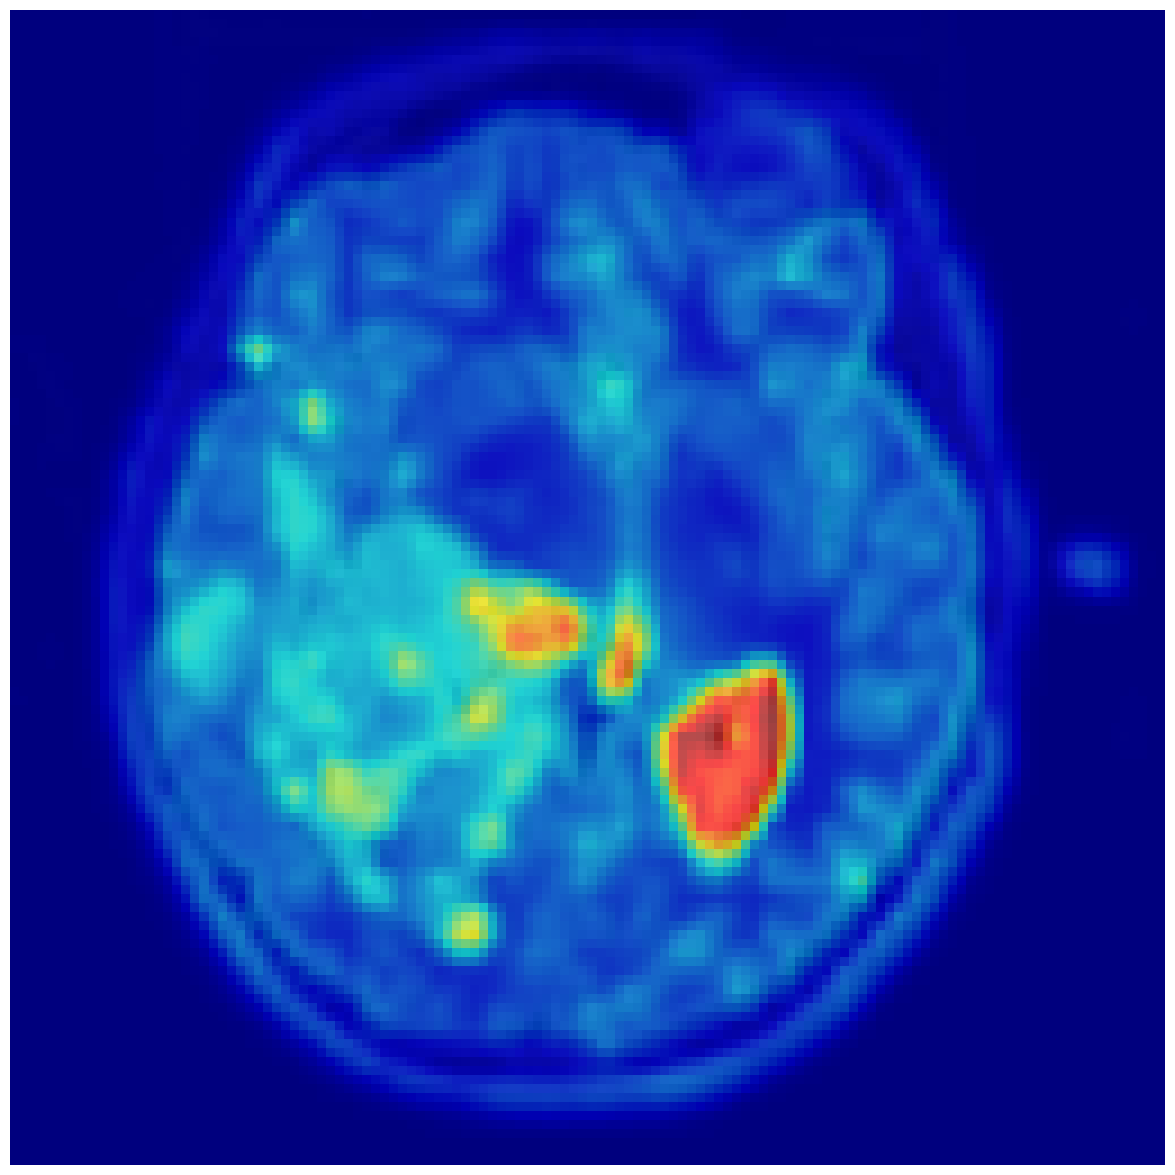

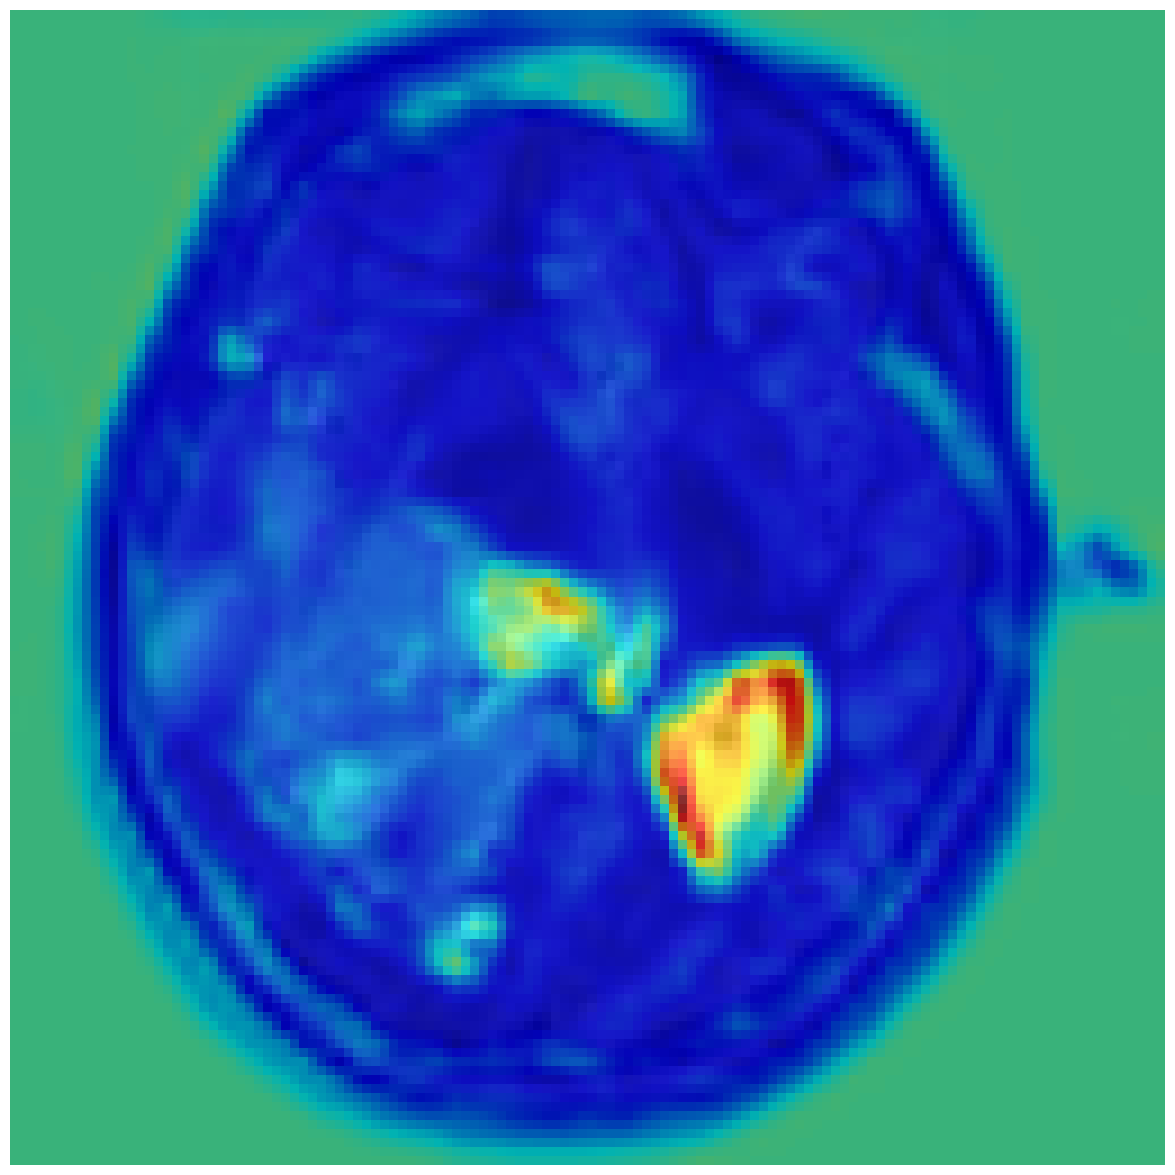

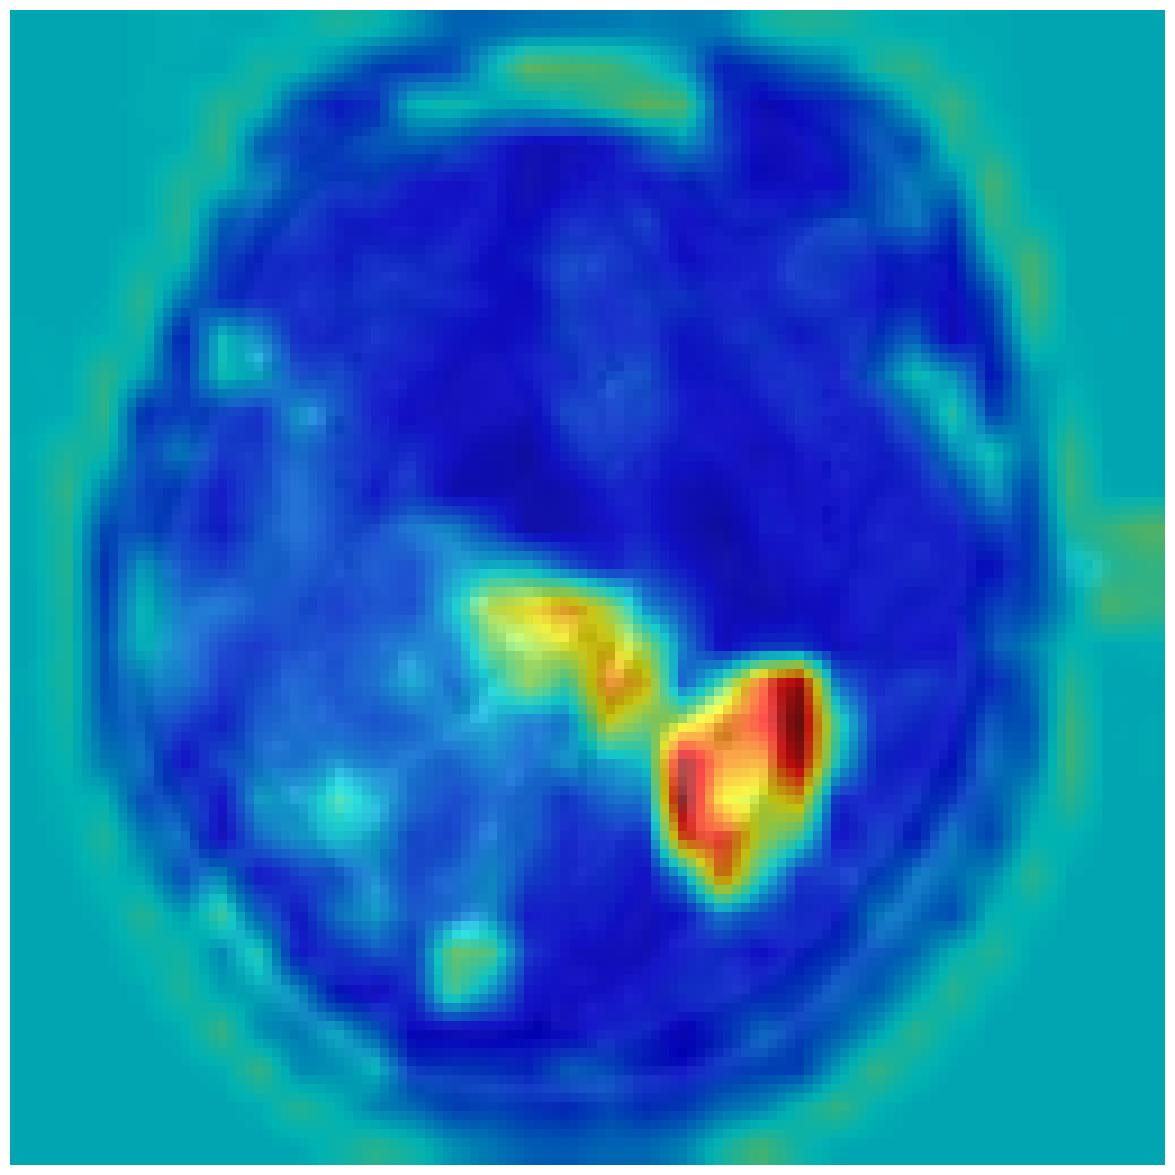

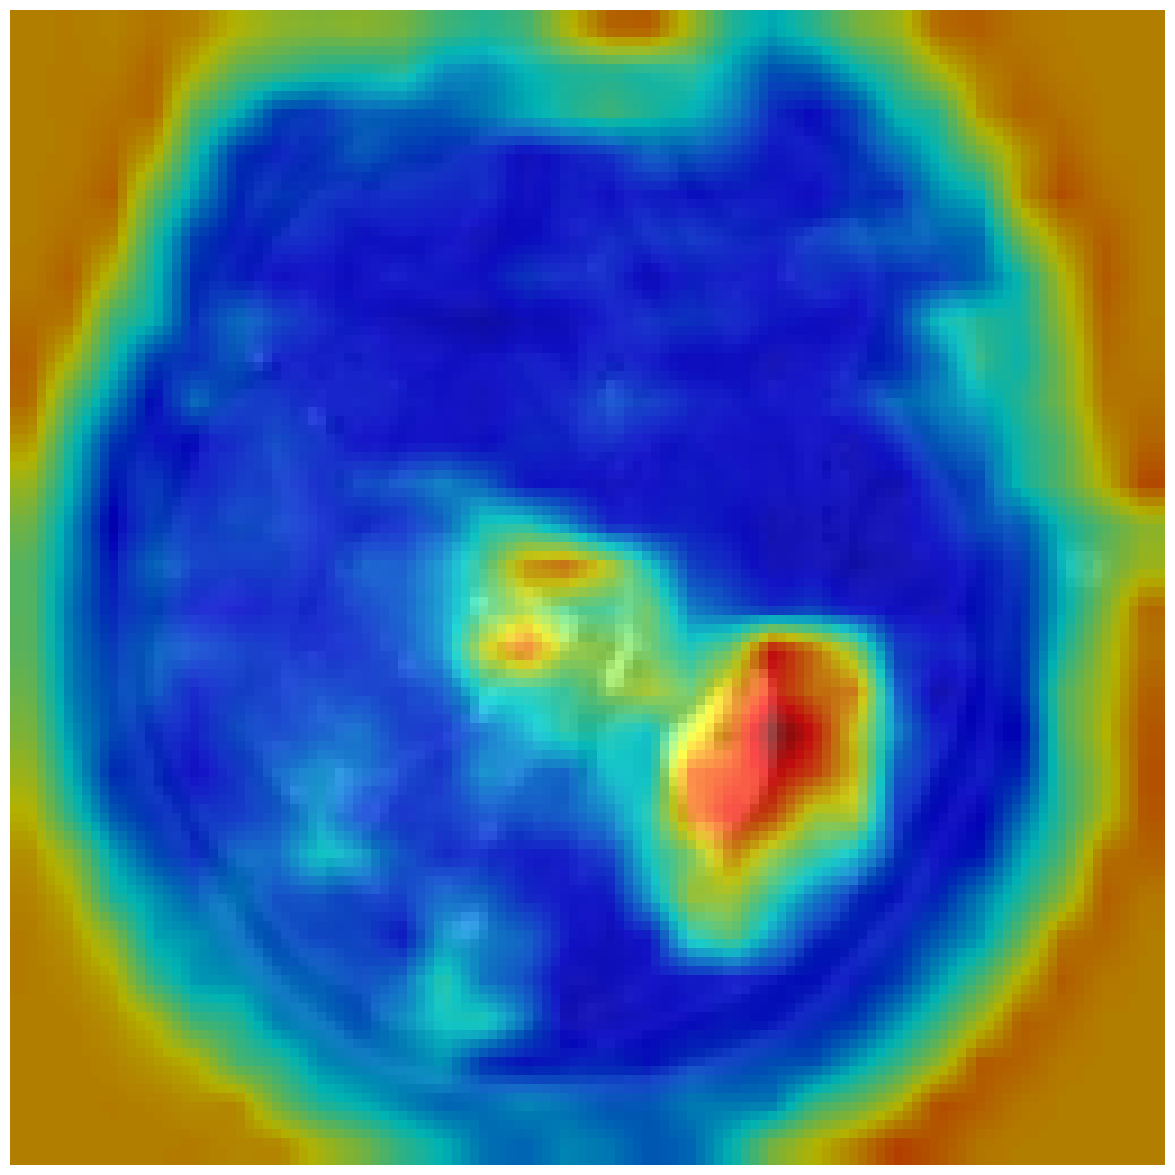

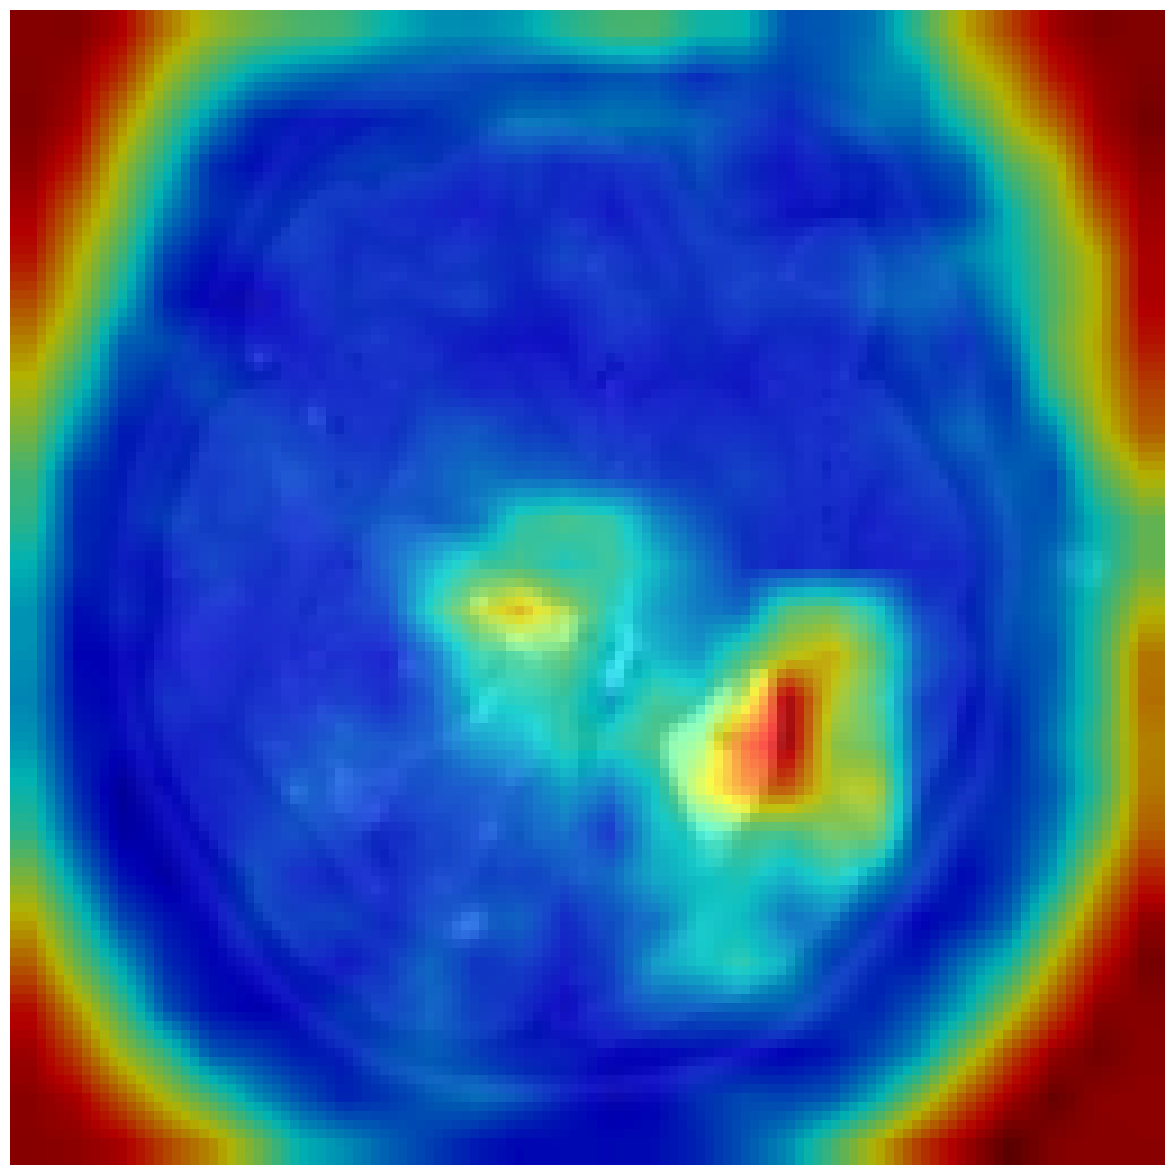

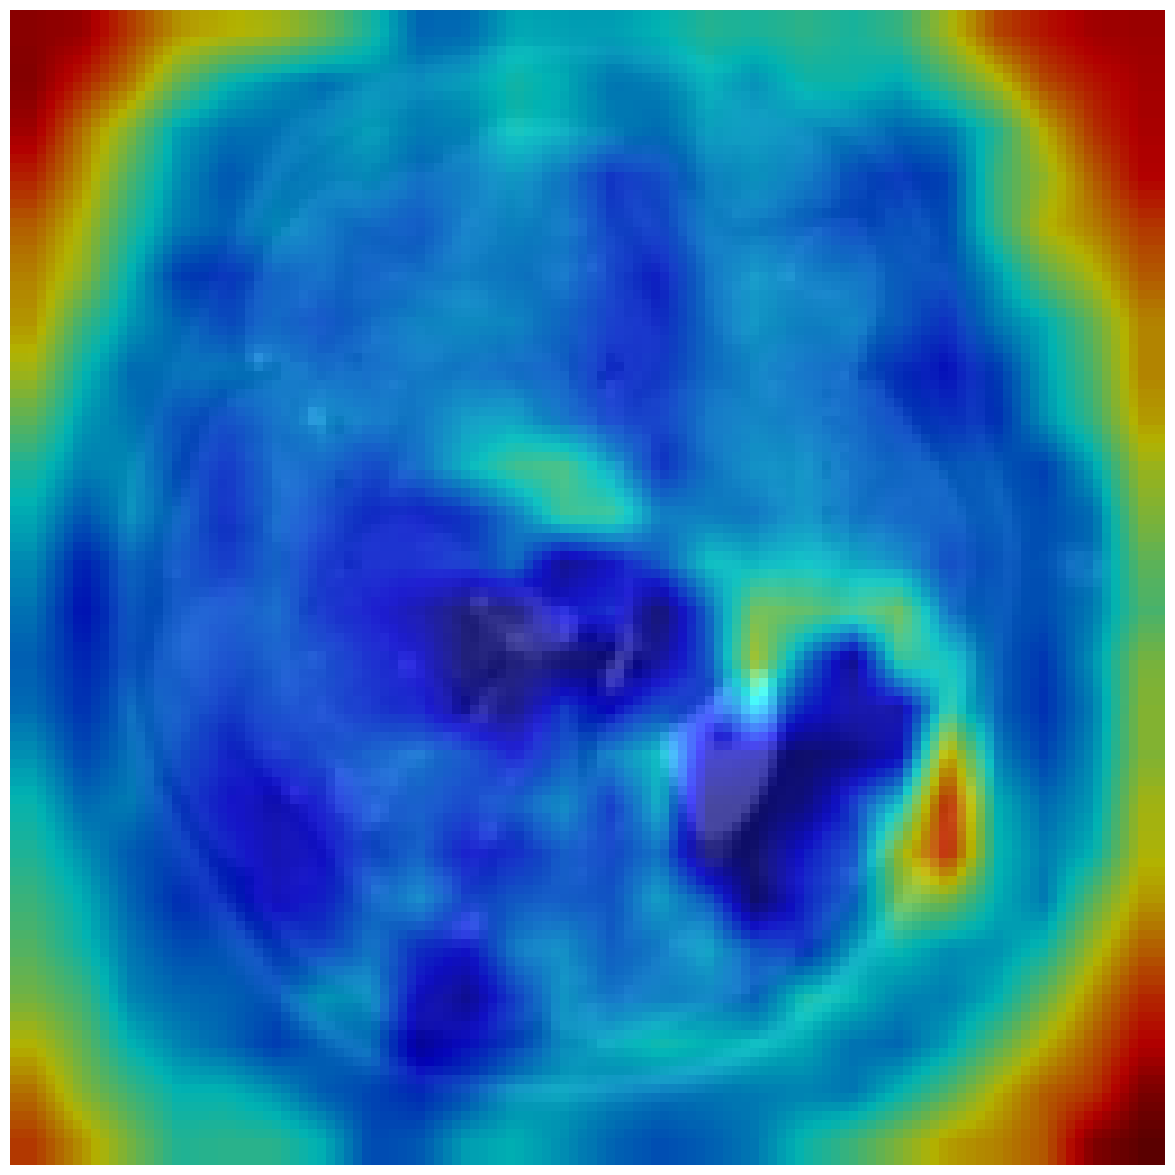

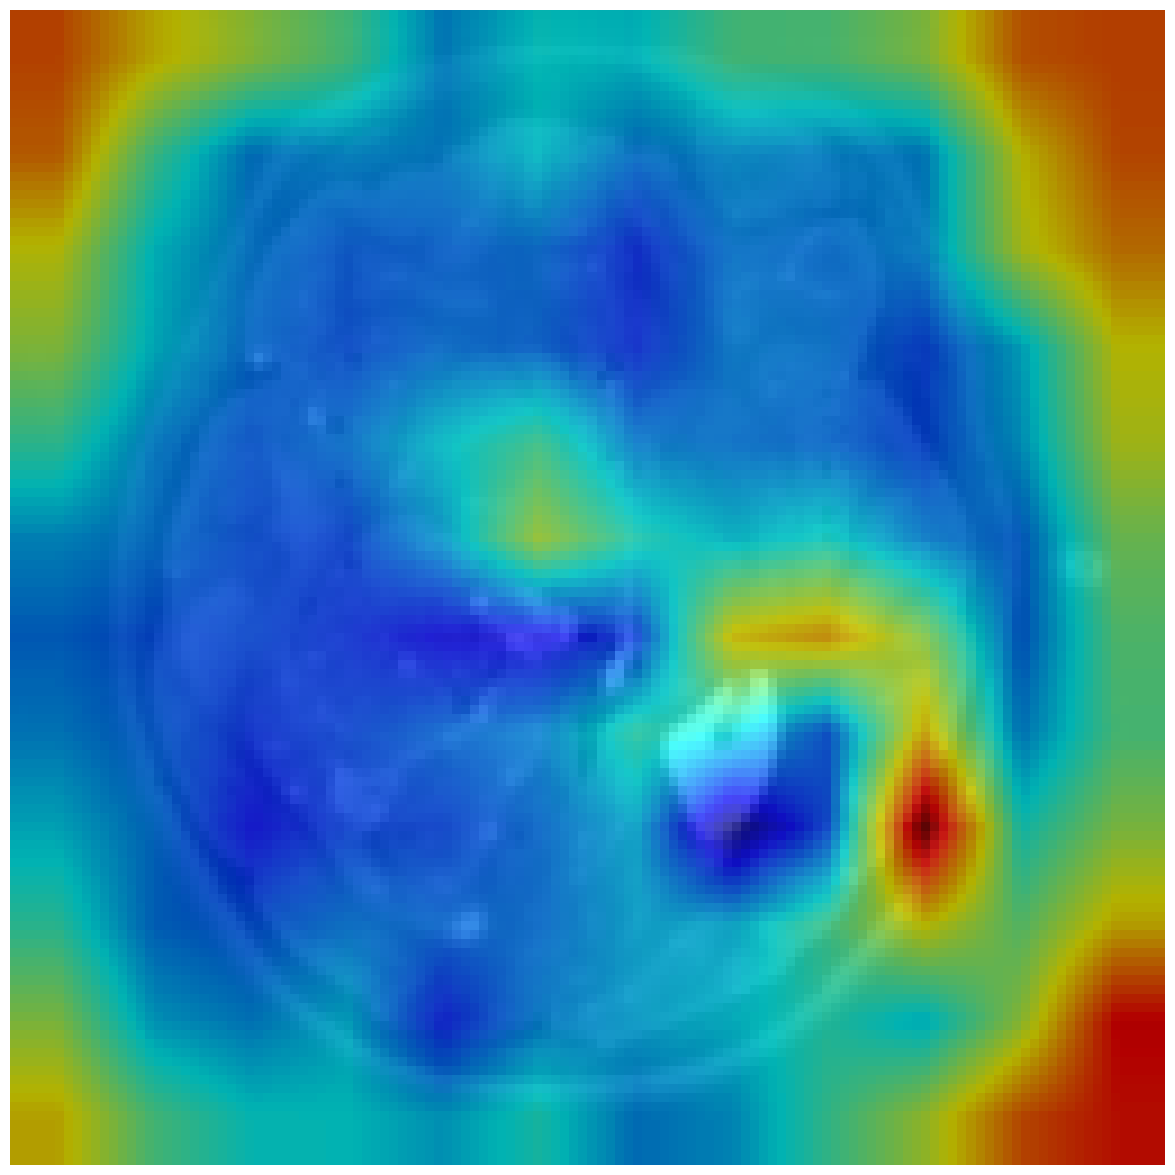

In [ ]:
plot_heatmaps(range(0, 1))
plot_heatmaps(range(1, 2))
plot_heatmaps(range(2, 3))
plot_heatmaps(range(3, 4))
plot_heatmaps(range(4, 5))
plot_heatmaps(range(5, 6))
plot_heatmaps(range(6, 7))
plot_heatmaps(range(7, 8))

In [ ]:
test_image1 = tf.expand_dims(x_test[100], axis=0)
print("Predicted label: ", label_names[np.argmax(model(test_image1))])
print("Actual label: ", label_names[np.argmax(y_test[100])])

Predicted label:  Oligodendroglioma
Actual label:  Oligodendroglioma


## Saliency Map

1. Forward pass: The input image is passed through the model to obtain the output predictions.

2. Compute the gradients: A gradient tape is used to record the operations performed during the forward pass and calculate the gradients of the output score corresponding to the predicted class with respect to the input image.

3. (Enhance saliency: Common techniques include taking the maximum gradient across color channels, applying smoothing filters, or multiplying the gradients with the input image to highlight the important regions.)

4. Normalize the saliency map: Normalized to a range such as [0, 1] by dividing them by their maximum value.

5. Visualize the saliency map: The saliency map is displayed as an overlay on the original image. The intensity of the saliency map at each pixel corresponds to the importance or relevance of that pixel in the model's decision-making process.

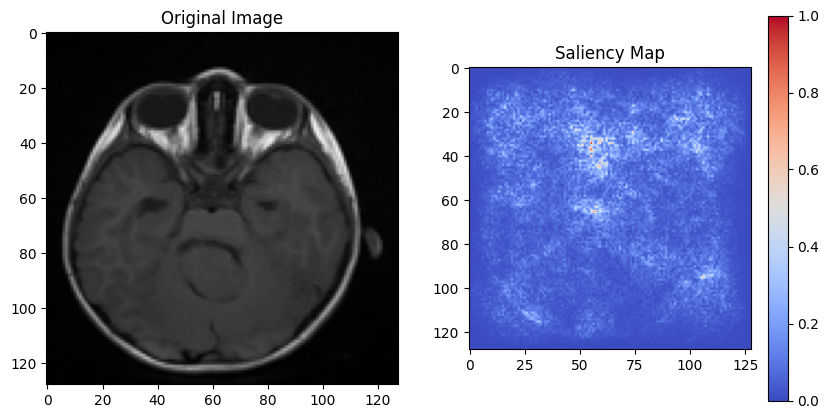


Correctly predicted as: Oligodendroglioma


In [ ]:
# Specify the input image index
input_image_index = 100

# Input the image to generate the saliency map on
img = x_test[input_image_index]
img = cv2.resize(img, (128, 128))

# Preprocess the image
test_image = tf.expand_dims(tf.cast(img, tf.float32), axis=0)
test_image = test_image / 255.0

# Calculate the saliency map
with tf.GradientTape() as tape:
    tape.watch(test_image)
    predictions = model(test_image)
    top_prediction = tf.argmax(predictions[0])
    top_score = predictions[0, top_prediction]

# Calculate the gradients of the top score with respect to the input image
gradients = tape.gradient(top_score, test_image)[0]
saliency_map = tf.reduce_max(tf.abs(gradients), axis=-1)

# Normalize the saliency map to the range [0, 1]
saliency_map = saliency_map / tf.reduce_max(saliency_map)

# Convert the saliency map and original image to numpy arrays
saliency_map = saliency_map.numpy()

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the original image
axs[0].imshow(img)
axs[0].set_title('Original Image')

# Plot the saliency map
saliency_img = axs[1].imshow(saliency_map, cmap='coolwarm')
axs[1].set_title('Saliency Map')

# Create a ScalarMappable object using the saliency map
saliency_colorbar = fig.colorbar(saliency_img, ax=axs[1])

# Display the figure
plt.show()

# Determine if it was labelled correctly
test_image1 = tf.expand_dims(x_test[input_image_index], axis=0)
predicted_label = label_names[np.argmax(model(test_image1))]
actual_label = label_names[np.argmax(y_test[input_image_index])]
if predicted_label == actual_label:
  print("\nCorrectly predicted as:", predicted_label)
else:
  print("\nIncorrectly predicted as: {}. Is actually: {}.".format(predicted_label, actual_label))